✅ Happiness data loaded successfully!
Shape: (158, 12)
       Country          Region  Happiness Rank  Happiness Score  \
0  Switzerland  Western Europe               1            7.587   
1      Iceland  Western Europe               2            7.561   

   Standard Error  Economy (GDP per Capita)   Family  \
0         0.03411                   1.39651  1.34951   
1         0.04884                   1.30232  1.40223   

   Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0                   0.94143  0.66557                        0.41978   
1                   0.94784  0.62877                        0.14145   

   Generosity  Dystopia Residual  
0     0.29678            2.51738  
1     0.43630            2.70201  

✅ GDP data loaded successfully!
Shape: (266, 70)
                  Country Name Country Code                Indicator Name  \
0                        Aruba          ABW  GDP per capita (current US$)   
1  Africa Eastern and Southern          AFE  GDP pe

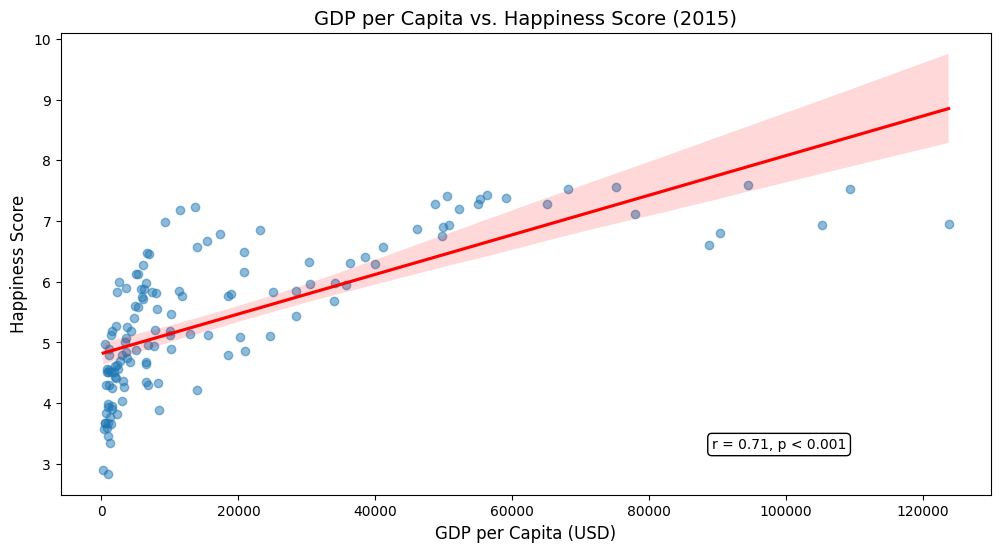


💾 Saved cleaned data to ../data/cleaned_data.csv
💾 Saved analysis results to ../results/analysis_results.json

🎉 Analysis complete! Final data preview:
       Country  Happiness Score  GDP_per_capita
0  Switzerland            7.587    94394.510680
1      Iceland            7.561    75121.015228
2      Denmark            7.527    68091.319114
3       Norway            7.522   109269.520580
4       Canada            7.427    56256.800726


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import json

# --------------------------------------------------
# 1. Load the Happiness Data
# --------------------------------------------------
try:
    happiness_path = "../data/raw_data/WorldHappinessReport/2015.csv"
    happiness = pd.read_csv(happiness_path)
    print("✅ Happiness data loaded successfully!")
    print(f"Shape: {happiness.shape}")
    print(happiness.head(2))
    
    # Check if 'Country' and 'Happiness Score' columns exist
    if not all(col in happiness.columns for col in ['Country', 'Happiness Score']):
        missing = [col for col in ['Country', 'Happiness Score'] if col not in happiness.columns]
        raise ValueError(f"Missing columns in happiness data: {missing}")
        
except Exception as e:
    print(f"❌ Error loading happiness data: {e}")
    if os.path.exists("../data/raw_data/WorldHappinessReport/"):
        print("\nFiles in WorldHappinessReport folder:")
        print(os.listdir("../data/raw_data/WorldHappinessReport/"))
    exit()

# --------------------------------------------------
# 2. Load the GDP Data (with World Bank formatting)
# --------------------------------------------------
try:
    gdp_path = "../data/raw_data/GDP_per_capita/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_122367.csv"
    gdp = pd.read_csv(gdp_path, skiprows=4)
    print("\n✅ GDP data loaded successfully!")
    print(f"Shape: {gdp.shape}")
    print(gdp.head(2))
    
    # Verify 2022 GDP column exists
    if '2022' not in gdp.columns:
        available_years = [col for col in gdp.columns if col.isdigit()]
        raise ValueError(f"'2022' column missing. Available years: {available_years}")
        
except Exception as e:
    print(f"❌ Error loading GDP data: {e}")
    if os.path.exists("../data/raw_data/GDP_per_capita/"):
        print("\nFiles in GDP_per_capita folder:")
        print(os.listdir("../data/raw_data/GDP_per_capita/"))
    exit()

# --------------------------------------------------
# 3. Data Cleaning
# --------------------------------------------------
print("\n🧹 Cleaning data...")

# Clean GDP data
gdp_clean = gdp[["Country Name", "2022"]].rename(
    columns={"Country Name": "Country", "2022": "GDP_per_capita"}
).dropna()

# Merge datasets
merged = pd.merge(
    happiness,
    gdp_clean,
    on="Country",
    how="inner"
)

# Validate merge
print(f"\n🔍 Merge result: {len(merged)} countries with complete data")
print(f"Original happiness data had {len(happiness)} countries")
print(f"GDP data had {len(gdp_clean)} countries")

# --------------------------------------------------
# 4. Analysis and Visualization
# --------------------------------------------------
print("\n📊 Running analysis...")

# 1. Basic Statistics
stats_df = merged[["Happiness Score", "GDP_per_capita"]].describe()
print("\n📈 Descriptive Statistics:")
print(stats_df)

# 2. Correlation Analysis
corr, p_value = stats.pearsonr(merged["GDP_per_capita"], merged["Happiness Score"])
print(f"\n📊 Pearson Correlation: {corr:.3f} (p-value: {p_value:.4f})")

# 3. Regression Analysis
X = merged[["GDP_per_capita"]]
y = merged["Happiness Score"]
model = LinearRegression()
model.fit(X, y)

print("\n🧮 Linear Regression Results:")
print(f"Slope (GDP coefficient): {model.coef_[0]:.5f}")
print(f"Intercept: {model.intercept_:.2f}")
print(f"R-squared: {model.score(X, y):.3f}")

# 4. Visualization
plt.figure(figsize=(12, 6))

# Scatterplot with regression line
sns.regplot(x="GDP_per_capita", y="Happiness Score", data=merged,
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("GDP per Capita vs. Happiness Score (2015)", fontsize=14)
plt.xlabel("GDP per Capita (USD)", fontsize=12)
plt.ylabel("Happiness Score", fontsize=12)

# Add correlation annotation
plt.annotate(f'r = {corr:.2f}, p < {0.001 if p_value < 0.001 else f"{p_value:.3f}"}',
             xy=(0.7, 0.1), xycoords='axes fraction',
             bbox=dict(boxstyle="round", fc="white"))

# Save plot
os.makedirs("../figures", exist_ok=True)
plt.savefig("../figures/gdp_happiness_scatter.png", dpi=300, bbox_inches='tight')
print("\n💾 Saved visualization to ../figures/gdp_happiness_scatter.png")
plt.show()

# --------------------------------------------------
# 5. Save Results
# --------------------------------------------------
# Save cleaned data
os.makedirs("../data", exist_ok=True)
merged.to_csv("../data/cleaned_data.csv", index=False)
print("\n💾 Saved cleaned data to ../data/cleaned_data.csv")

# Save analysis results
os.makedirs("../results", exist_ok=True)
results = {
    "correlation": corr,
    "p_value": p_value,
    "regression": {
        "slope": model.coef_[0],
        "intercept": model.intercept_,
        "r_squared": model.score(X, y)
    },
    "sample_size": len(merged)
}

with open("../results/analysis_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("💾 Saved analysis results to ../results/analysis_results.json")

# Final preview
print("\n🎉 Analysis complete! Final data preview:")
print(merged[["Country", "Happiness Score", "GDP_per_capita"]].head())

In [2]:
import sys
print(sys.executable)

c:\Users\User\AppData\Local\Programs\Python\Python313\python.exe


In [3]:
import sys
!{sys.executable} -m pip install seaborn scikit-learn matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
